# Exercise 6

This week we will practice how to work with OpenStreetMap data and conduct network analysis in Python.

Problem 1 (8 points)

There are two csv-files in the /data folder:

    origins.csv
    destinations.csv

The files contain coordinates of the origin and destination points in certain area of the world.

# 1: Your task is to find out where the points are located based on the coordinates found in the files

 - use your GIS skills to find out the solution, for example
        - detect the location using geocoding techniques (see hints)
        - detect the location using visualization techniques, and to plot the points on top of a background map.
 - Save the answer to a variable area_of_interest and print out the answer with command: print("The points are located in: %s" % area_of_interest) (the correct answer is a city or a town somewhere in the world).

In [1]:
import plotly_express as px
from shapely.geometry import Point, MultiPoint, Polygon
from fiona.crs import from_epsg
from pyproj import CRS
import geopandas as gpd
import osmnx as ox
import networkx as nx # based on python implementation of the Dijkstra algorithm
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Read File
origins_fp = "origins.csv"
destinations_fp = "destinations.csv"
# Create GeoDataFrames
origins = pd.read_csv(origins_fp)
destinations = pd.read_csv(destinations_fp)
# Append DataFrames
data = origins.append(destinations)

In [3]:
data = data.dropna()

In [4]:
data['geom'] = data['y'].map(str) + ',' + data['x'].map(str)

In [5]:
data['geom'][0]

0    59.4052,24.6159
0    59.4395,24.8441
Name: geom, dtype: object

In [6]:
# Import the geocoding tool
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent="autogis_xx")
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [7]:
data['address'] = data['geom'].apply(rgeocode)

In [8]:
data = data.reset_index(drop=True)
data.head()

,x,y,geom,address
0,24.6159,59.4052,"59.4052,24.6159","(Astangu mini-Rimi, 4, Kotermaa, Astangu, Haab..."
1,24.6407,59.4074,"59.4074,24.6407","(Grossi Toidukaubad, 35b, Järveotsa tee, Väike..."
2,24.6686,59.4018,"59.4018,24.6686","(41, Ehitajate tee, Mustamäe, Mustamäe linnaos..."
3,24.6980,59.4477,"59.4477,24.698","(Grossi, 3, Kari, Pelguranna, Põhja-Tallinn, P..."
4,24.7680,59.4303,"59.4303,24.768","(Grossi Toidukaubad, 14, Lastekodu, Keldrimäe,..."


In [9]:
print("The points are located in: %s" % data['address'])

The points are located in: 0     (Astangu mini-Rimi, 4, Kotermaa, Astangu, Haab...
1     (Grossi Toidukaubad, 35b, Järveotsa tee, Väike...
2     (41, Ehitajate tee, Mustamäe, Mustamäe linnaos...
3     (Grossi, 3, Kari, Pelguranna, Põhja-Tallinn, P...
4     (Grossi Toidukaubad, 14, Lastekodu, Keldrimäe,...
5     (28a, Majaka, Sikupilli, Lasnamäe linnaosa, Ta...
6     (Metro Plaza, 2, Viru väljak, Südalinn, Keskli...
7     (115, Randvere tee, Mähe, Pirita linnaosa, Tal...
8     (103, A. H. Tammsaare tee, Sääse, Mustamäe lin...
9     (6, Väike-Ameerika, Uus Maailm, Kesklinn, Kesk...
10    (13a, Ümera, Seli, Lasnamäe linnaosa, Tallinn,...
11    (53, Endla, Lilleküla, Kristiine, Kristiine li...
12    (2a, Paasiku, Katleri, Lasnamäe linnaosa, Tall...
13    (1, Narva mnt, Südalinn, Kesklinn, Kesklinna l...
14    (Rimi, 35, Juhkentali, Kesklinn, Kesklinna lin...
15    (7, Aia, Vanalinn, Kesklinn, Kesklinna linnaos...
16    (19, Vikerlase, Laagna, Lasnamäe, Lasnamäe lin...
17    (556a, Pärnu mn

# 2: Retrieve OpenStreetMap data (only streets that can be driven with car) from the area where the points are located.

 - You should use a Polygon specifying the extent where all the points are located to fetch the data with .graph_from_polygon() function

In [10]:
# Insert Point objects into the column geometry based on the coordinate columns 
def create_point(row):
    point = Point(row['x'], row['y'])
    return point

In [11]:
# Apply create_point function to each row
data['geometry'] = data.apply(create_point, axis=1)

In [12]:
from pyproj import CRS
# Convert that DataFrame into a GeoDataFrame called geo
geo = gpd.GeoDataFrame(data, geometry='geometry', crs=CRS.from_epsg(4326).to_wkt())

In [13]:
# Note: the resulting coordinates from the total_bounds are in this order: [xmin, ymin, xmax, ymax]
geo['geometry'].total_bounds

array([24.5598, 59.3224, 24.8921, 59.4912])

In [14]:
# bbox_coords = [[xmin, ymax], [xmin, ymin], [xmax, ymin], [xmax, ymax]]
bbox_coords = [[24.5598, 59.4912], [24.5598, 59.3224], [24.8921, 59.3224], [24.8921,59.4912]]

In [15]:
extent = Polygon(bbox_coords)

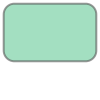

In [16]:
extent.buffer(0.05, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0)

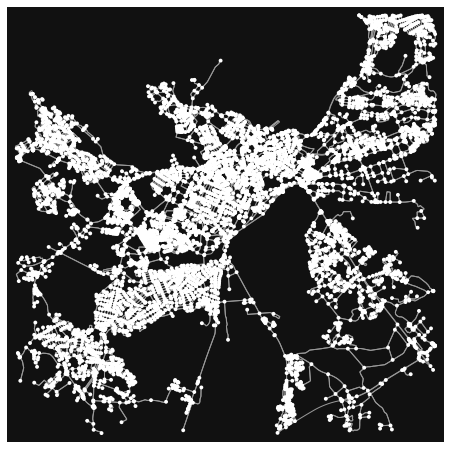

In [17]:
g = ox.graph_from_polygon(extent, network_type = 'drive')
fig, ax = ox.plot_graph(g)